In [1]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset
import numpy as np
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr.client import NumPyClient
from flwr.common import Context, NDArrays, Scalar, ndarrays_to_parameters, EvaluateRes
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedProx  # Changed from FedAvg to FedProx
from flwr.simulation import run_simulation
from collections import OrderedDict
from typing import Dict, Tuple, List
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from flwr.server.client_proxy import ClientProxy
from flwr.common.logger import log
from logging import INFO

from flwr.server.strategy import DifferentialPrivacyClientSideFixedClipping

# Additional imports for plotting and data saving
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Define constants
NUM_CLIENTS = 5
NUM_ROUNDS = 50
BATCH_SIZE = 32

NOISE_MULTIPLIER = 1.0  # Increased to 1.0 for stronger privacy
CLIPPING_NORM = 20.0     # Threshold for clipping model updates

# Function to run simulation for a given scenario
def run_simulation_scenario(ATTACKER_IDS, USE_IID):
    # Define partitioner based on IID or non-IID
    if USE_IID:
        # IID Partitioning
        partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
    else:
        # Non-IID Partitioning using Dirichlet distribution
        alpha = 1.0  # Adjust alpha for desired heterogeneity
        partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, alpha=alpha, partition_by="label")

    # Load the CIFAR-10 dataset and partition it
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})

    def get_cifar10_dataloaders(cifar10_dataset, batch_size: int):
        """
        Function to handle CIFAR-10 data loaders.
        Applies appropriate transformations for CIFAR-10 images.
        """
        # CIFAR-10 normalization parameters
        pytorch_transforms = Compose([
            ToTensor(),
            Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

        # Prepare transformation functions
        def apply_transforms(batch):
            """Apply transforms to the partition from FederatedDataset."""
            batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
            return batch

        cifar10_dataset = cifar10_dataset.with_transform(apply_transforms)

        # Construct PyTorch dataloader
        dataloader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=True)
        return dataloader

    # Define the neural network model suitable for CIFAR-10
    class Net(nn.Module):
        def __init__(self, num_classes: int) -> None:
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Changed input channels from 1 to 3 for CIFAR-10
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Adjusted for 32x32 images
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Functions to set and get model parameters
    def set_params(model, parameters):
        """Replace model parameters with those passed as parameters."""
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

    def get_params(model):
        """Extract model parameters as a list of NumPy arrays."""
        return [val.cpu().numpy() for _, val in model.state_dict().items()]

    # Training function with label flipping for attackers and proximal term
    def train(net, trainloader, optimizer, device="cpu", is_attacker=False, global_params=None, mu=0.1):
        """Train the network on the training set with optional proximal term."""
        criterion = torch.nn.CrossEntropyLoss()
        net.to(device)
        net.train()
        for batch in trainloader:
            images, labels = batch["img"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            if is_attacker:
                # Flip labels for attackers (simple label flipping)
                labels = (labels + 1) % 10
            outputs = net(images)
            loss = criterion(outputs, labels)
            if global_params is not None:
                # Add proximal term
                proximal_loss = 0.0
                for param, global_param in zip(net.parameters(), global_params.values()):
                    proximal_loss += torch.norm(param - global_param.to(device))**2
                loss += (mu / 2) * proximal_loss
            loss.backward()
            optimizer.step()

    # Testing function with metric calculations
    def test(net, testloader, device):
        """Validate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        net.to(device)
        net.eval()
        correct, loss = 0, 0.0
        all_preds = []
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for batch in testloader:
                images, labels = batch["img"].to(device), batch["label"].to(device)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())
        accuracy = correct / len(testloader.dataset)

        # Compute metrics
        kappa = cohen_kappa_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Check if there are at least two classes in y_true
        unique_classes = np.unique(all_labels)
        if len(unique_classes) > 1:
            try:
                all_labels_bin = label_binarize(all_labels, classes=list(range(10)))
                all_outputs_array = np.array(all_outputs)
                roc_auc = roc_auc_score(all_labels_bin, all_outputs_array, average='macro', multi_class='ovr')
            except ValueError:
                roc_auc = float('nan')  # Assign NaN if ROC AUC cannot be computed
        else:
            roc_auc = float('nan')  # Assign NaN if only one class is present

        metrics = {
            "accuracy": accuracy,
            "kappa": kappa,
            "f1_score": f1,
            "roc_auc": roc_auc,
        }
        return loss, accuracy, metrics

    # Initialize metrics lists
    rounds_list = []
    accuracy_list = []
    kappa_list = []
    f1_list = []
    roc_auc_list = []

    # Define the FlowerClient class
    class FlowerClient(NumPyClient):
        def __init__(self, trainloader, valloader, is_attacker=False) -> None:
            super().__init__()
            self.trainloader = trainloader
            self.valloader = valloader
            self.model = Net(num_classes=10)
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.is_attacker = is_attacker

        def fit(self, parameters, config):
            """Train the model locally with FedProx proximal term."""
            # Set model parameters
            set_params(self.model, parameters)

            # Extract global parameters from config
            global_params = OrderedDict(
                (k, torch.tensor(v)) for k, v in zip(self.model.state_dict().keys(), parameters)
            )

            # Get proximal_mu from config
            mu = config.get("proximal_mu", 0.1)  # Default to 0.1 if not set

            # Define the optimizer
            optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

            # Train the model with proximal term
            train(
                self.model,
                self.trainloader,
                optim,
                self.device,
                is_attacker=self.is_attacker,
                global_params=global_params,
                mu=mu  # Proximal term coefficient
            )

            # **Apply Client-Side Fixed Clipping**
            updated_params = get_params(self.model)
            clipped_params = []
            for param in updated_params:
                norm = np.linalg.norm(param)
                if norm > CLIPPING_NORM:
                    param = param * (CLIPPING_NORM / norm)
                clipped_params.append(param)

            # Return clipped parameters
            return clipped_params, len(self.trainloader.dataset), {}

        def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
            """Evaluate the model locally."""
            set_params(self.model, parameters)
            loss, accuracy, metrics = test(self.model, self.valloader, self.device)
            return float(loss), len(self.valloader.dataset), metrics

    # Define the client function
    def client_fn(context: Context):
        """Create a Flower client representing a participant in the federated learning."""
        partition_id = int(context.node_config["partition-id"])
        partition = fds.load_partition(partition_id, "train")
        # Partition into train/validation
        partition_train_val = partition.train_test_split(test_size=0.1, seed=42)
        # Get dataloaders
        trainloader = get_cifar10_dataloaders(partition_train_val["train"], batch_size=BATCH_SIZE)
        valloader = get_cifar10_dataloaders(partition_train_val["test"], batch_size=BATCH_SIZE)
        # Determine if the client is an attacker
        is_attacker = partition_id in ATTACKER_IDS
        return FlowerClient(trainloader=trainloader, valloader=valloader, is_attacker=is_attacker).to_client()

    # Define function to provide fit config with proximal_mu
    def fit_config(rnd: int):
        """Return training configuration dict for each round."""
        return {"proximal_mu": 0.1}  # Set proximal_mu value

    # Define custom strategy to log metrics
    class CustomFedProx(FedProx):  # Changed from CustomFedAvg to CustomFedProx and FedProx
        def __init__(self, *args, **kwargs):
            self.rounds_list = kwargs.pop('rounds_list')
            self.accuracy_list = kwargs.pop('accuracy_list')
            self.kappa_list = kwargs.pop('kappa_list')
            self.f1_list = kwargs.pop('f1_list')
            self.roc_auc_list = kwargs.pop('roc_auc_list')
            proximal_mu = kwargs.pop('proximal_mu', 0.1)  # Extract proximal_mu
            super().__init__(*args, proximal_mu=proximal_mu, **kwargs)  # Pass proximal_mu to FedProx

        def aggregate_evaluate(
            self,
            rnd: int,
            results: List[Tuple[ClientProxy, EvaluateRes]],
            failures: List[BaseException],
        ):
            """Aggregate evaluation results using weighted average and log metrics per round."""
            if not results:
                return None, {}

            # Use weighted average to aggregate metrics
            num_examples_total = sum([r[1].num_examples for r in results])

            # Initialize sums
            accuracy_sum = 0.0
            kappa_sum = 0.0
            f1_sum = 0.0
            roc_auc_sum = 0.0
            roc_auc_weight = 0

            for _, evaluate_res in results:
                accuracy_sum += evaluate_res.metrics.get("accuracy", 0.0) * evaluate_res.num_examples
                kappa_sum += evaluate_res.metrics.get("kappa", 0.0) * evaluate_res.num_examples
                f1_sum += evaluate_res.metrics.get("f1_score", 0.0) * evaluate_res.num_examples
                roc_auc = evaluate_res.metrics.get("roc_auc", float('nan'))
                if not np.isnan(roc_auc):
                    roc_auc_sum += roc_auc * evaluate_res.num_examples
                    roc_auc_weight += evaluate_res.num_examples

            # Compute weighted averages
            accuracy = accuracy_sum / num_examples_total
            kappa = kappa_sum / num_examples_total
            f1 = f1_sum / num_examples_total
            roc_auc = roc_auc_sum / roc_auc_weight if roc_auc_weight > 0 else float('nan')

            # Log metrics
            log(INFO, f"Round {rnd} evaluation metrics:")
            log(INFO, f"Accuracy: {accuracy:.4f}")
            log(INFO, f"Kappa: {kappa:.4f}")
            log(INFO, f"F1 Score: {f1:.4f}")
            if not np.isnan(roc_auc):
                log(INFO, f"ROC AUC: {roc_auc:.4f}")
            else:
                log(INFO, f"ROC AUC: Undefined (only one class present in y_true)")

            # Store metrics
            self.rounds_list.append(rnd)
            self.accuracy_list.append(accuracy)
            self.kappa_list.append(kappa)
            self.f1_list.append(f1)
            self.roc_auc_list.append(roc_auc if not np.isnan(roc_auc) else 0.0)

            # Return aggregated loss and metrics
            return super().aggregate_evaluate(rnd, results, failures)

    # Define the server function
    def server_fn(context: Context):
        # Instantiate the model
        model = Net(num_classes=10)
        ndarrays = get_params(model)
        # Convert model parameters to flwr.common.Parameters
        global_model_init = ndarrays_to_parameters(ndarrays)

        # Define the strategy with FedProx parameters
        strategy = CustomFedProx(
            fraction_fit=1.0,        # All clients participate in training
            fraction_evaluate=1.0,   # All clients participate in evaluation
            initial_parameters=global_model_init,  # Initialized global model
            rounds_list=rounds_list,
            accuracy_list=accuracy_list,
            kappa_list=kappa_list,
            f1_list=f1_list,
            roc_auc_list=roc_auc_list,
            proximal_mu=0.1,  # Proximal term coefficient for FedProx
            on_fit_config_fn=fit_config  # Function to provide fit config
        )

        # Construct ServerConfig
        config = ServerConfig(num_rounds=NUM_ROUNDS)

        # Wrap everything into a ServerAppComponents object
        return ServerAppComponents(strategy=strategy, config=config)

    # Create your ServerApp and ClientApp
    server_app = ServerApp(server_fn=server_fn)
    from flwr.client import ClientApp
    client_app = ClientApp(client_fn=client_fn)

    # Run the simulation
    run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_name="ray",
        verbose_logging=True,
    )

    # After the simulation, collect the metrics
    metrics = {
        "rounds": rounds_list,
        "accuracy": accuracy_list,
        "kappa": kappa_list,
        "f1_score": f1_list,
        "roc_auc": roc_auc_list,
    }

    return metrics

# Function to run all scenarios
def run_all_scenarios():
    scenarios = [
        #{"name": "Baseline_IID", "ATTACKER_IDS": [], "USE_IID": True},
        #{"name": "One_Attacker_IID", "ATTACKER_IDS": [0], "USE_IID": True},
        #{"name": "Two_Attackers_IID", "ATTACKER_IDS": [0, 1], "USE_IID": True},
        #{"name": "Baseline_NonIID", "ATTACKER_IDS": [], "USE_IID": False},
        #{"name": "One_Attacker_NonIID", "ATTACKER_IDS": [0], "USE_IID": False},
        {"name": "Two_Attackers_NonIID", "ATTACKER_IDS": [0, 1], "USE_IID": False},
    ]

    results = {}

    for scenario in scenarios:
        print(f"\nRunning Scenario: {scenario['name']}")
        metrics = run_simulation_scenario(scenario["ATTACKER_IDS"], scenario["USE_IID"])
        results[scenario["name"]] = metrics

        # Plot the metrics
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(metrics["rounds"], metrics["accuracy"], marker='o', color='blue')
        plt.title(f"Accuracy Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics["rounds"], metrics["kappa"], marker='o', color='green')
        plt.title(f"Kappa Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel('Kappa')
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics["rounds"], metrics["f1_score"], marker='o', color='red')
        plt.title(f"F1 Score Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel("F1 Score")
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics["rounds"], metrics["roc_auc"], marker='o', color='purple')
        plt.title(f"ROC AUC Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel("ROC AUC")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Save metrics to CSV
        df = pd.DataFrame(metrics)
        df.to_csv(f"{scenario['name']}_metrics.csv", index=False)

    return results

# Run all scenarios
#results = run_all_scenarios()


DEBUG 2024-11-23 23:40:17,746:     Asyncio event loop already running.
DEBUG 2024-11-23 23:40:17,747:     Logger propagate set to False
DEBUG 2024-11-23 23:40:17,748:     Pre-registering run with id 1400711239594528788
DEBUG 2024-11-23 23:40:17,749:     Using InMemoryState
DEBUG 2024-11-23 23:40:17,750:     Using InMemoryState
DEBUG 2024-11-23 23:40:17,751:     Buffer time delay: 5s
INFO 2024-11-23 23:40:17,755:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-23 23:40:17,755:      
INFO 2024-11-23 23:40:17,756:      [INIT]
INFO 2024-11-23 23:40:17,756:      Using initial global parameters provided by strategy
INFO 2024-11-23 23:40:17,756:      Starting evaluation of initial global parameters
INFO 2024-11-23 23:40:17,757:      Evaluation returned no results (`None`)
INFO 2024-11-23 23:40:17,757:      
INFO 2024-11-23 23:40:17,758:      [ROUND 1]



Testing with NOISE_MULTIPLIER=0.1, CLIPPING_NORM=50.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-23 23:40:22,752:     Using InMemoryState
DEBUG 2024-11-23 23:40:22,753:     Registered 5 nodes
DEBUG 2024-11-23 23:40:22,754:     Supported backends: ['ray']
DEBUG 2024-11-23 23:40:22,755:     Initialising: RayBackend
DEBUG 2024-11-23 23:40:22,755:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-23 23:40:23,451	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-23 23:40:24,022:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-23 23:40:24,037:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-23 23:40:24,038:     Using InMemoryState
(ClientAppActor pid=1011651) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1011651)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-23 23:40:34,144:      aggreg

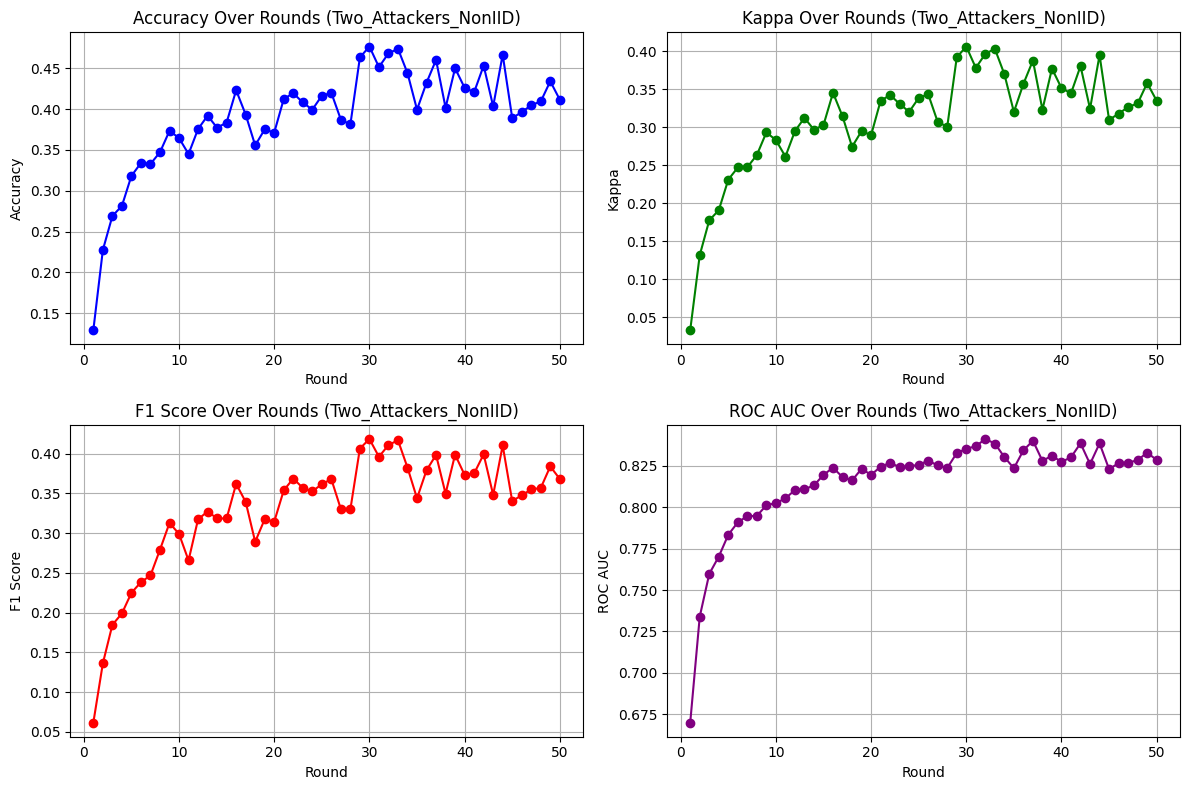

DEBUG 2024-11-23 23:47:35,324:     Asyncio event loop already running.
DEBUG 2024-11-23 23:47:35,325:     Logger propagate set to False
DEBUG 2024-11-23 23:47:35,325:     Pre-registering run with id 2099099141764626453
DEBUG 2024-11-23 23:47:35,326:     Using InMemoryState
DEBUG 2024-11-23 23:47:35,327:     Using InMemoryState
DEBUG 2024-11-23 23:47:35,329:     Buffer time delay: 5s
INFO 2024-11-23 23:47:35,331:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-23 23:47:35,331:      
INFO 2024-11-23 23:47:35,332:      [INIT]
INFO 2024-11-23 23:47:35,332:      Using initial global parameters provided by strategy
INFO 2024-11-23 23:47:35,333:      Starting evaluation of initial global parameters
INFO 2024-11-23 23:47:35,333:      Evaluation returned no results (`None`)
INFO 2024-11-23 23:47:35,333:      
INFO 2024-11-23 23:47:35,333:      [ROUND 1]



Testing with NOISE_MULTIPLIER=0.1, CLIPPING_NORM=5.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-23 23:47:40,330:     Using InMemoryState
DEBUG 2024-11-23 23:47:40,331:     Registered 5 nodes
DEBUG 2024-11-23 23:47:40,331:     Supported backends: ['ray']
DEBUG 2024-11-23 23:47:40,332:     Initialising: RayBackend
DEBUG 2024-11-23 23:47:40,332:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-23 23:47:41,332:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-23 23:47:42,166	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-23 23:47:42,711:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-23 23:47:42,711:     Using InMemoryState
(ClientAppActor pid=1022169) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1022169)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-23 23:47:53,618:      aggreg

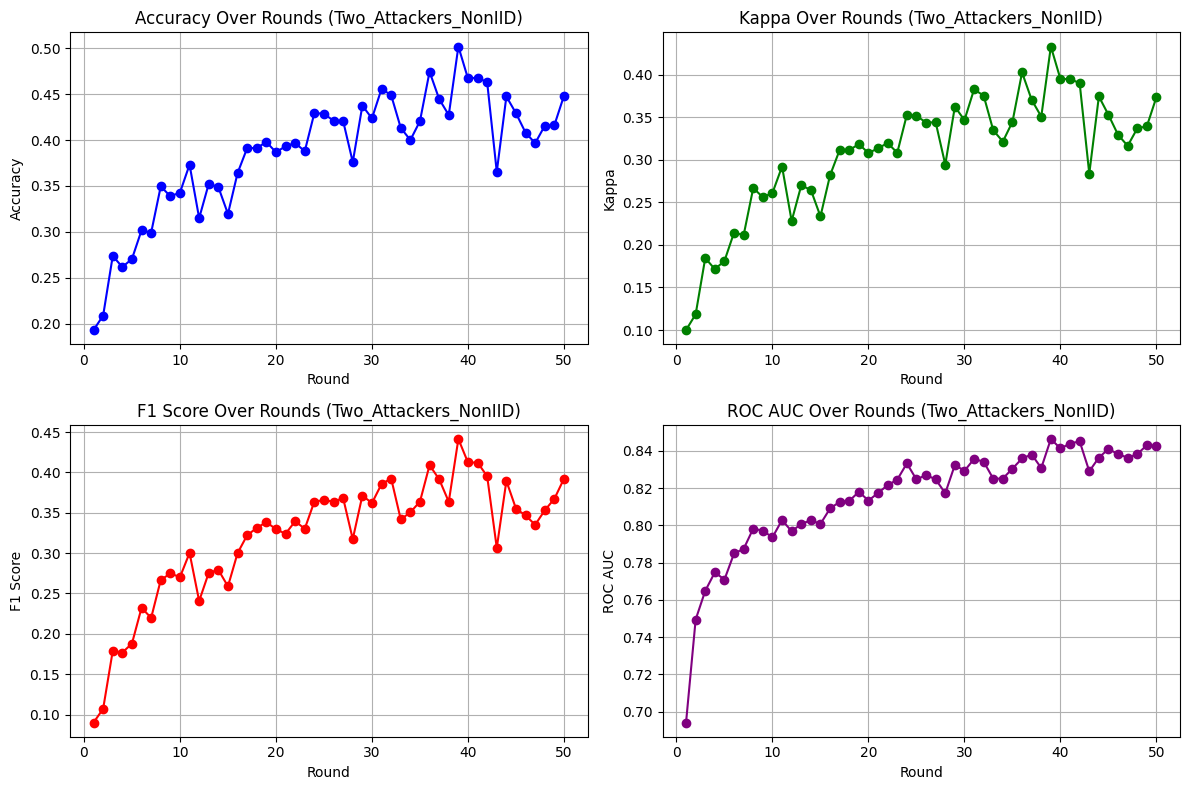

DEBUG 2024-11-23 23:54:44,919:     Asyncio event loop already running.
DEBUG 2024-11-23 23:54:44,919:     Logger propagate set to False
DEBUG 2024-11-23 23:54:44,920:     Pre-registering run with id 134627276487361882
DEBUG 2024-11-23 23:54:44,921:     Using InMemoryState
DEBUG 2024-11-23 23:54:44,922:     Using InMemoryState
DEBUG 2024-11-23 23:54:44,922:     Buffer time delay: 5s
INFO 2024-11-23 23:54:44,925:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-23 23:54:44,925:      
INFO 2024-11-23 23:54:44,926:      [INIT]
INFO 2024-11-23 23:54:44,926:      Using initial global parameters provided by strategy
INFO 2024-11-23 23:54:44,927:      Starting evaluation of initial global parameters
INFO 2024-11-23 23:54:44,927:      Evaluation returned no results (`None`)
INFO 2024-11-23 23:54:44,927:      
INFO 2024-11-23 23:54:44,928:      [ROUND 1]



Testing with NOISE_MULTIPLIER=1.0, CLIPPING_NORM=50.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-23 23:54:49,924:     Using InMemoryState
DEBUG 2024-11-23 23:54:49,925:     Registered 5 nodes
DEBUG 2024-11-23 23:54:49,925:     Supported backends: ['ray']
DEBUG 2024-11-23 23:54:49,926:     Initialising: RayBackend
DEBUG 2024-11-23 23:54:49,926:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-23 23:54:50,890	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-23 23:54:51,426:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-23 23:54:51,438:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-23 23:54:51,441:     Using InMemoryState
(ClientAppActor pid=1032657) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1032657)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1032657) /home/fredri

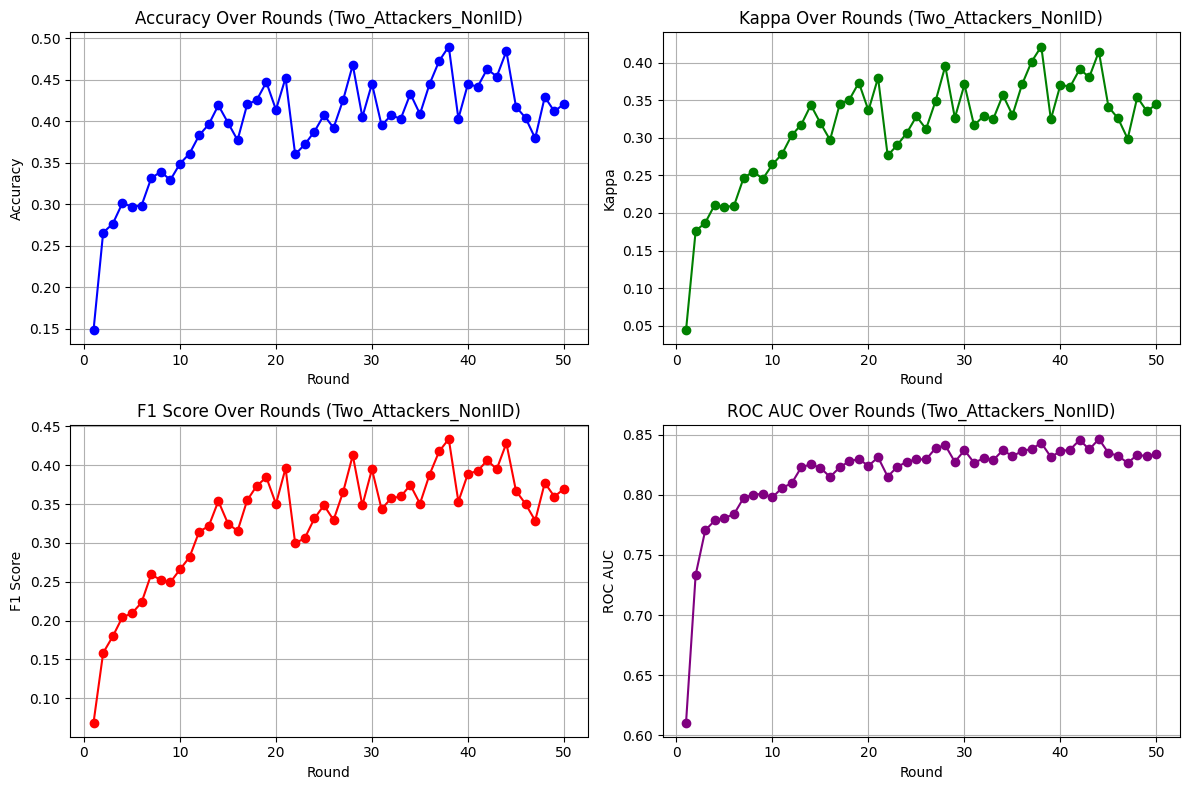

DEBUG 2024-11-24 00:01:52,401:     Asyncio event loop already running.
DEBUG 2024-11-24 00:01:52,402:     Logger propagate set to False
DEBUG 2024-11-24 00:01:52,403:     Pre-registering run with id 10377658756655704107
DEBUG 2024-11-24 00:01:52,404:     Using InMemoryState
DEBUG 2024-11-24 00:01:52,404:     Using InMemoryState
DEBUG 2024-11-24 00:01:52,406:     Buffer time delay: 5s
INFO 2024-11-24 00:01:52,408:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:01:52,409:      
INFO 2024-11-24 00:01:52,409:      [INIT]
INFO 2024-11-24 00:01:52,409:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:01:52,410:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:01:52,410:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:01:52,410:      
INFO 2024-11-24 00:01:52,411:      [ROUND 1]



Testing with NOISE_MULTIPLIER=0.5, CLIPPING_NORM=5.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:01:57,407:     Using InMemoryState
DEBUG 2024-11-24 00:01:57,408:     Registered 5 nodes
DEBUG 2024-11-24 00:01:57,408:     Supported backends: ['ray']
DEBUG 2024-11-24 00:01:57,408:     Initialising: RayBackend
DEBUG 2024-11-24 00:01:57,409:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 00:01:58,233	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 00:01:58,738:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 00:01:58,752:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:01:58,753:     Using InMemoryState
(ClientAppActor pid=1043186) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1043186)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-24 00:02:09,259:      aggreg

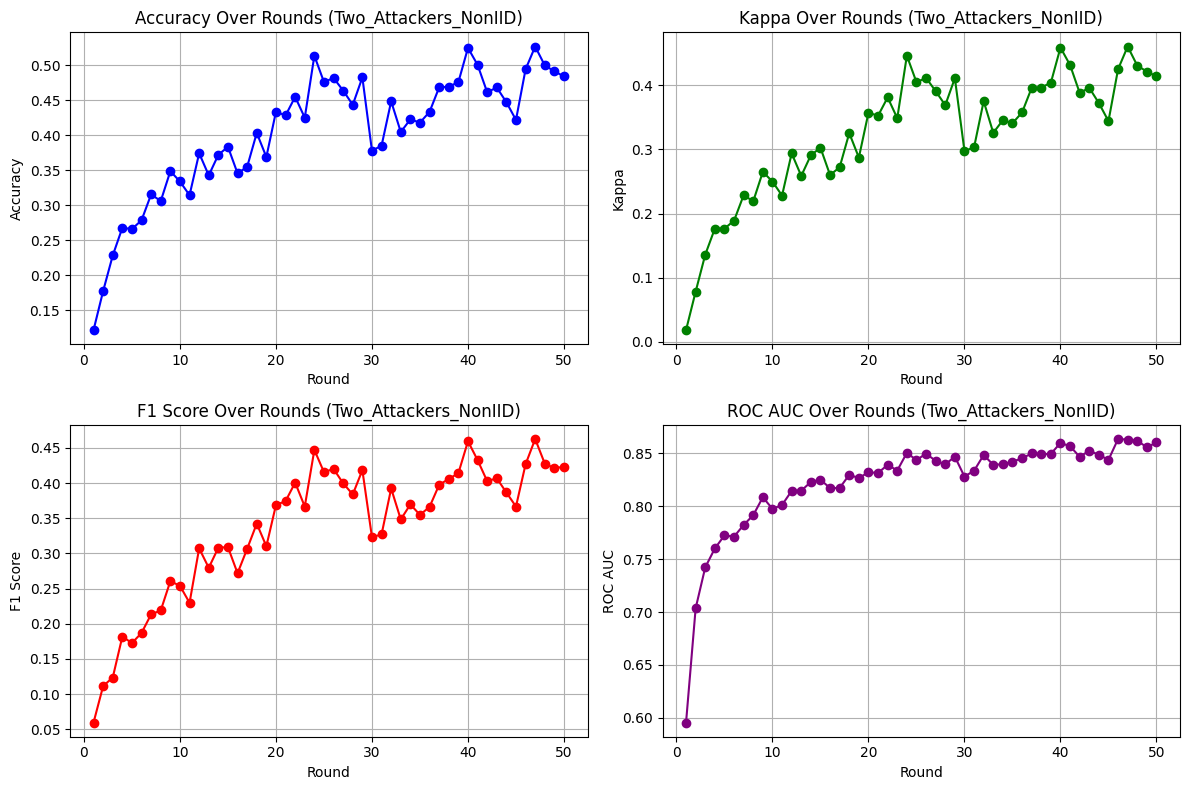

DEBUG 2024-11-24 00:09:02,088:     Asyncio event loop already running.
DEBUG 2024-11-24 00:09:02,088:     Logger propagate set to False
DEBUG 2024-11-24 00:09:02,089:     Pre-registering run with id 13242493384489349098
DEBUG 2024-11-24 00:09:02,089:     Using InMemoryState
DEBUG 2024-11-24 00:09:02,090:     Using InMemoryState
DEBUG 2024-11-24 00:09:02,092:     Buffer time delay: 5s
INFO 2024-11-24 00:09:02,093:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:09:02,094:      
INFO 2024-11-24 00:09:02,094:      [INIT]
INFO 2024-11-24 00:09:02,094:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:09:02,095:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:09:02,095:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:09:02,095:      
INFO 2024-11-24 00:09:02,096:      [ROUND 1]



Testing with NOISE_MULTIPLIER=2.0, CLIPPING_NORM=50.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:09:07,093:     Using InMemoryState
DEBUG 2024-11-24 00:09:07,094:     Registered 5 nodes
DEBUG 2024-11-24 00:09:07,094:     Supported backends: ['ray']
DEBUG 2024-11-24 00:09:07,095:     Initialising: RayBackend
DEBUG 2024-11-24 00:09:07,096:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-24 00:09:08,095:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-24 00:09:08,949	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-24 00:09:09,468:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:09:09,469:     Using InMemoryState
(ClientAppActor pid=1053668) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1053668)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1053668) /home/fredri

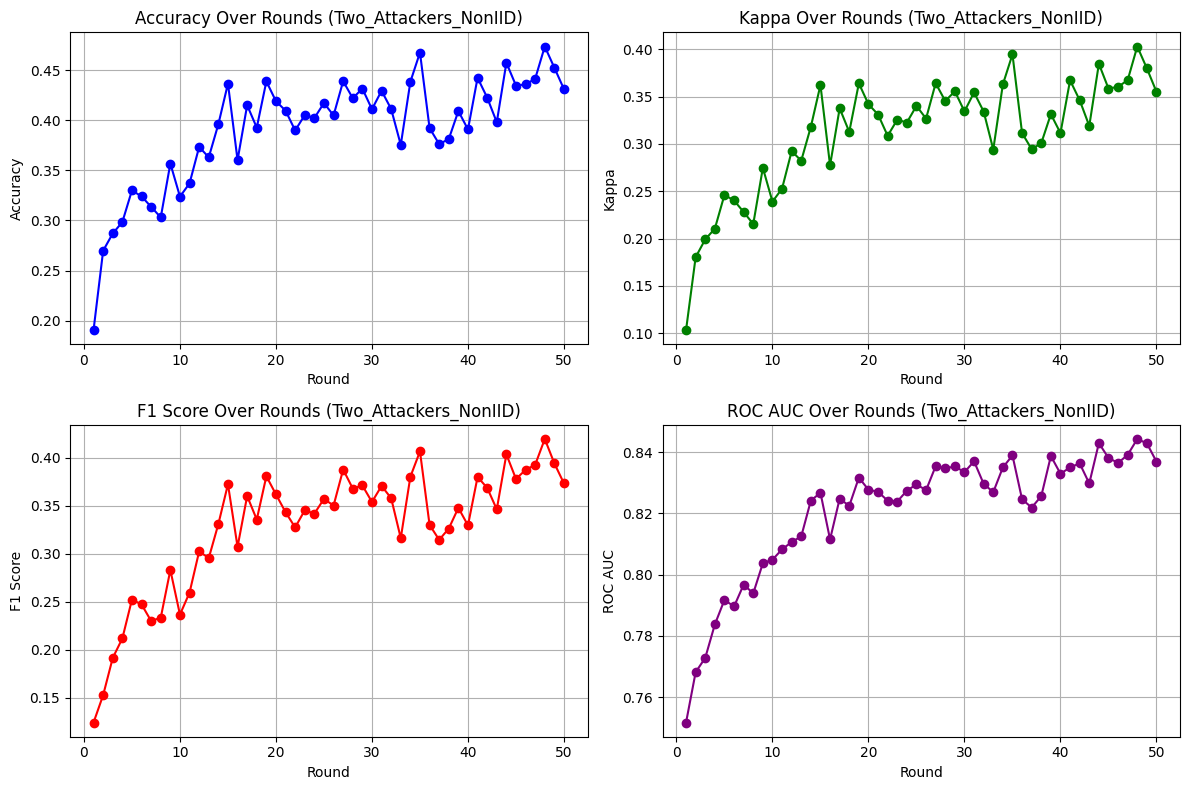

DEBUG 2024-11-24 00:16:10,898:     Asyncio event loop already running.
DEBUG 2024-11-24 00:16:10,898:     Logger propagate set to False
DEBUG 2024-11-24 00:16:10,899:     Pre-registering run with id 10773220032456451318
DEBUG 2024-11-24 00:16:10,899:     Using InMemoryState
DEBUG 2024-11-24 00:16:10,900:     Using InMemoryState
DEBUG 2024-11-24 00:16:10,901:     Buffer time delay: 5s
INFO 2024-11-24 00:16:10,903:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:16:10,904:      
INFO 2024-11-24 00:16:10,904:      [INIT]
INFO 2024-11-24 00:16:10,905:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:16:10,905:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:16:10,905:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:16:10,906:      
INFO 2024-11-24 00:16:10,906:      [ROUND 1]



Testing with NOISE_MULTIPLIER=2.0, CLIPPING_NORM=10.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:16:15,901:     Using InMemoryState
DEBUG 2024-11-24 00:16:15,902:     Registered 5 nodes
DEBUG 2024-11-24 00:16:15,903:     Supported backends: ['ray']
DEBUG 2024-11-24 00:16:15,903:     Initialising: RayBackend
DEBUG 2024-11-24 00:16:15,903:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 00:16:16,855	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 00:16:17,401:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 00:16:17,417:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:16:17,417:     Using InMemoryState
(ClientAppActor pid=1064128) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1064128)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-24 00:16:28,122:      aggreg

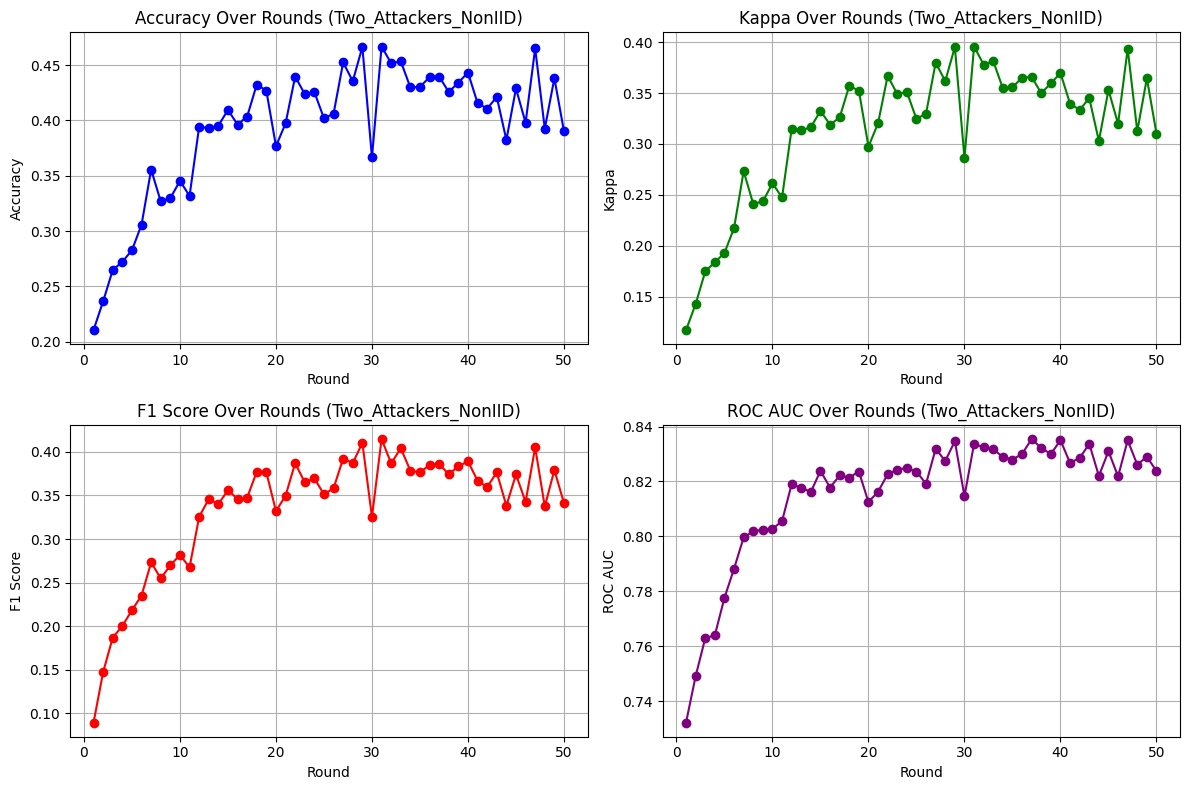

DEBUG 2024-11-24 00:23:15,491:     Asyncio event loop already running.
DEBUG 2024-11-24 00:23:15,492:     Logger propagate set to False
DEBUG 2024-11-24 00:23:15,493:     Pre-registering run with id 10296064466427642158
DEBUG 2024-11-24 00:23:15,493:     Using InMemoryState
DEBUG 2024-11-24 00:23:15,493:     Using InMemoryState
DEBUG 2024-11-24 00:23:15,494:     Buffer time delay: 5s
INFO 2024-11-24 00:23:15,497:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:23:15,497:      
INFO 2024-11-24 00:23:15,498:      [INIT]
INFO 2024-11-24 00:23:15,498:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:23:15,498:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:23:15,499:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:23:15,499:      
INFO 2024-11-24 00:23:15,499:      [ROUND 1]



Testing with NOISE_MULTIPLIER=0.1, CLIPPING_NORM=20.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:23:20,495:     Using InMemoryState
DEBUG 2024-11-24 00:23:20,496:     Registered 5 nodes
DEBUG 2024-11-24 00:23:20,496:     Supported backends: ['ray']
DEBUG 2024-11-24 00:23:20,497:     Initialising: RayBackend
DEBUG 2024-11-24 00:23:20,497:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 00:23:21,442	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 00:23:21,993:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 00:23:22,005:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:23:22,006:     Using InMemoryState
(ClientAppActor pid=1074564) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1074564)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1074564) /home/fredri

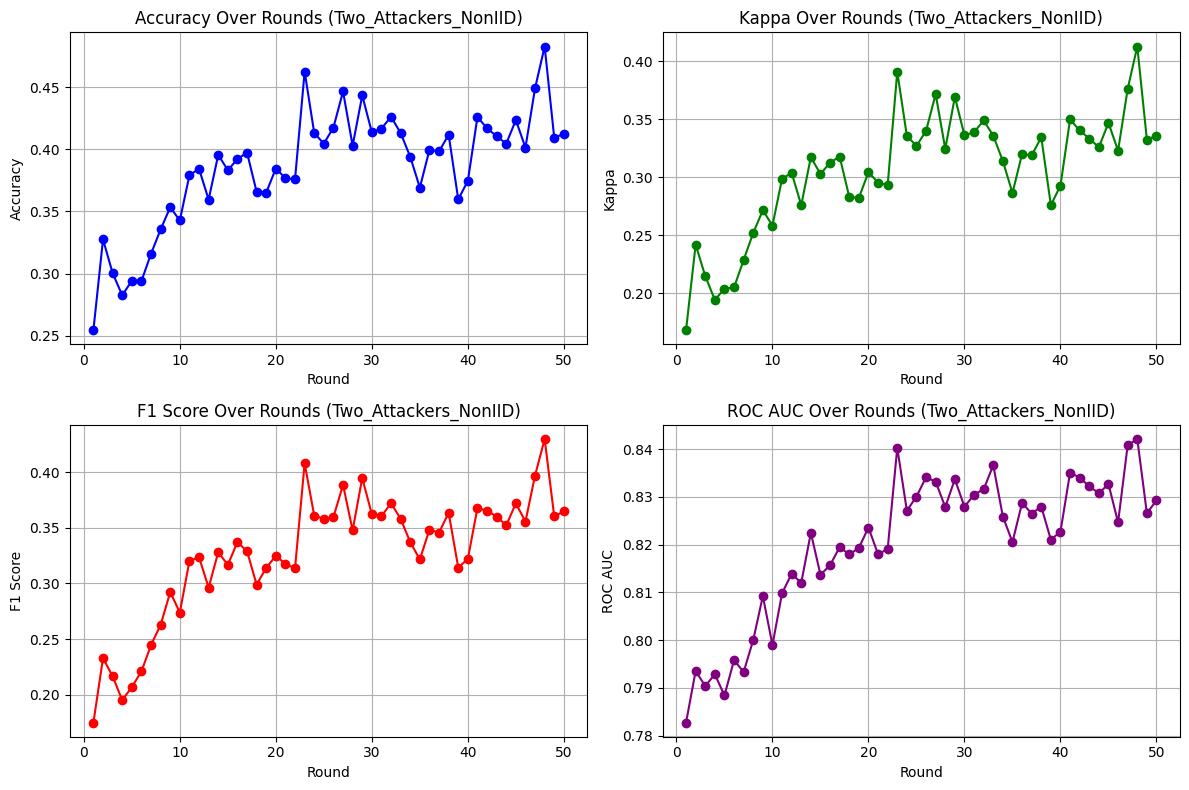

DEBUG 2024-11-24 00:30:16,277:     Asyncio event loop already running.
DEBUG 2024-11-24 00:30:16,278:     Logger propagate set to False
DEBUG 2024-11-24 00:30:16,279:     Pre-registering run with id 5862008671921541466
DEBUG 2024-11-24 00:30:16,279:     Using InMemoryState
DEBUG 2024-11-24 00:30:16,280:     Using InMemoryState
DEBUG 2024-11-24 00:30:16,281:     Buffer time delay: 5s
INFO 2024-11-24 00:30:16,283:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:30:16,284:      
INFO 2024-11-24 00:30:16,284:      [INIT]
INFO 2024-11-24 00:30:16,285:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:30:16,285:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:30:16,286:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:30:16,286:      
INFO 2024-11-24 00:30:16,286:      [ROUND 1]



Testing with NOISE_MULTIPLIER=0.1, CLIPPING_NORM=10.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:30:21,282:     Using InMemoryState
DEBUG 2024-11-24 00:30:21,282:     Registered 5 nodes
DEBUG 2024-11-24 00:30:21,283:     Supported backends: ['ray']
DEBUG 2024-11-24 00:30:21,283:     Initialising: RayBackend
DEBUG 2024-11-24 00:30:21,284:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
2024-11-24 00:30:22,121	INFO worker.py:1819 -- Started a local Ray instance.
INFO 2024-11-24 00:30:22,644:      configure_fit: strategy sampled 2 clients (out of 5)
DEBUG 2024-11-24 00:30:22,656:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:30:22,656:     Using InMemoryState
(ClientAppActor pid=1084980) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1084980)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1084980) /home/fredri

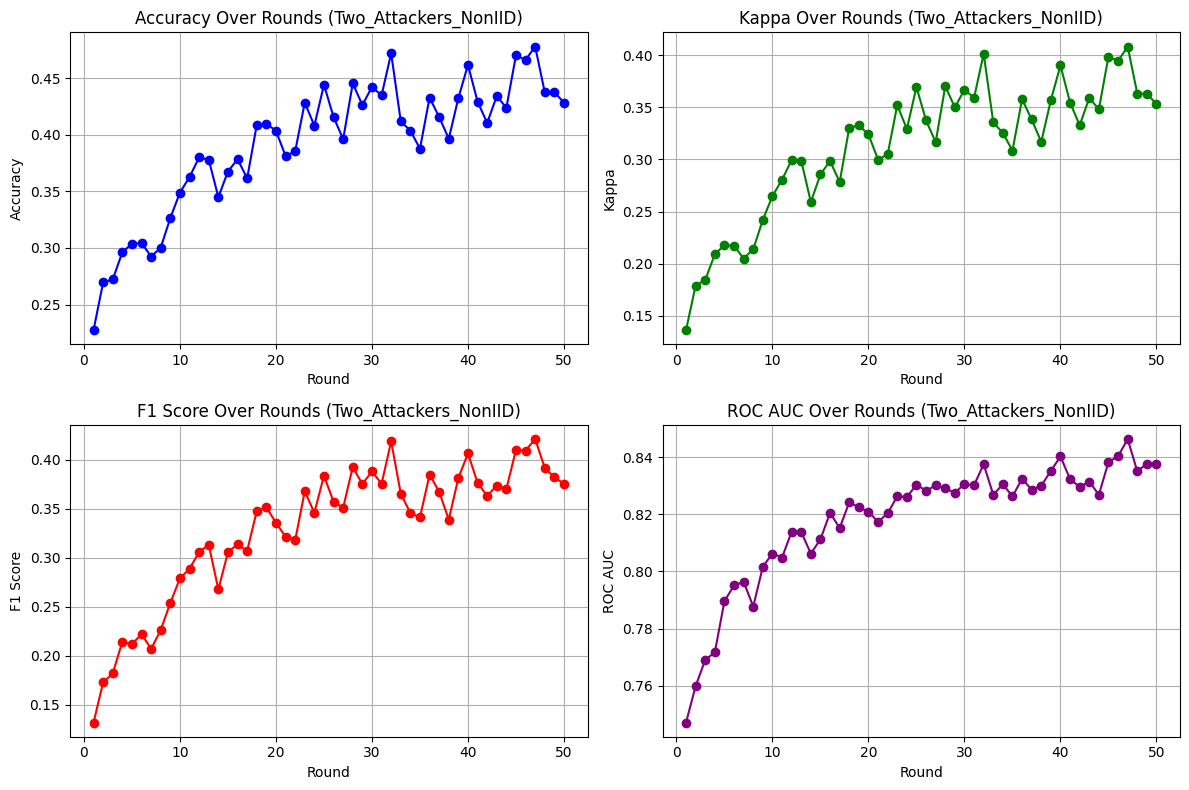

DEBUG 2024-11-24 00:37:22,872:     Asyncio event loop already running.
DEBUG 2024-11-24 00:37:22,873:     Logger propagate set to False
DEBUG 2024-11-24 00:37:22,874:     Pre-registering run with id 7795665726408321537
DEBUG 2024-11-24 00:37:22,875:     Using InMemoryState
DEBUG 2024-11-24 00:37:22,875:     Using InMemoryState
DEBUG 2024-11-24 00:37:22,876:     Buffer time delay: 5s
INFO 2024-11-24 00:37:22,879:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:37:22,879:      
INFO 2024-11-24 00:37:22,880:      [INIT]
INFO 2024-11-24 00:37:22,880:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:37:22,881:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:37:22,881:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:37:22,881:      
INFO 2024-11-24 00:37:22,882:      [ROUND 1]



Testing with NOISE_MULTIPLIER=1.0, CLIPPING_NORM=5.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:37:27,878:     Using InMemoryState
DEBUG 2024-11-24 00:37:27,879:     Registered 5 nodes
DEBUG 2024-11-24 00:37:27,879:     Supported backends: ['ray']
DEBUG 2024-11-24 00:37:27,879:     Initialising: RayBackend
DEBUG 2024-11-24 00:37:27,880:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-24 00:37:28,880:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-24 00:37:28,932	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-24 00:37:29,450:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:37:29,451:     Using InMemoryState
(ClientAppActor pid=1095427) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1095427)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=1095427) /home/fredri

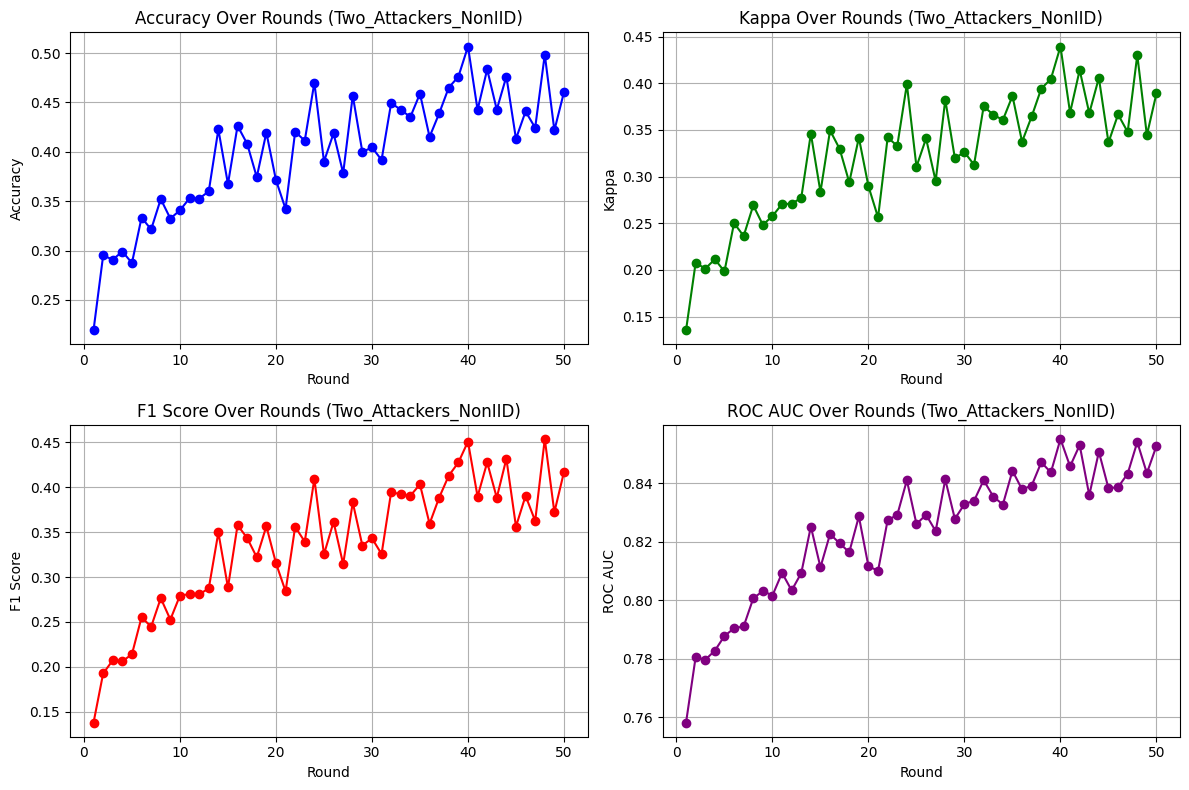

DEBUG 2024-11-24 00:44:37,713:     Asyncio event loop already running.
DEBUG 2024-11-24 00:44:37,714:     Logger propagate set to False
DEBUG 2024-11-24 00:44:37,714:     Pre-registering run with id 8692371653815100446
DEBUG 2024-11-24 00:44:37,715:     Using InMemoryState
DEBUG 2024-11-24 00:44:37,715:     Using InMemoryState
DEBUG 2024-11-24 00:44:37,716:     Buffer time delay: 5s
INFO 2024-11-24 00:44:37,718:      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO 2024-11-24 00:44:37,719:      
INFO 2024-11-24 00:44:37,719:      [INIT]
INFO 2024-11-24 00:44:37,720:      Using initial global parameters provided by strategy
INFO 2024-11-24 00:44:37,720:      Starting evaluation of initial global parameters
INFO 2024-11-24 00:44:37,720:      Evaluation returned no results (`None`)
INFO 2024-11-24 00:44:37,721:      
INFO 2024-11-24 00:44:37,721:      [ROUND 1]



Testing with NOISE_MULTIPLIER=2.0, CLIPPING_NORM=5.0

Running Scenario: Two_Attackers_NonIID


DEBUG 2024-11-24 00:44:42,717:     Using InMemoryState
DEBUG 2024-11-24 00:44:42,718:     Registered 5 nodes
DEBUG 2024-11-24 00:44:42,719:     Supported backends: ['ray']
DEBUG 2024-11-24 00:44:42,719:     Initialising: RayBackend
DEBUG 2024-11-24 00:44:42,719:     Backend config: {'init_args': {}, 'client_resources': {'num_cpus': 2, 'num_gpus': 0}, 'actor': {'tensorflow': 0}}
INFO 2024-11-24 00:44:43,720:      configure_fit: strategy sampled 2 clients (out of 5)
2024-11-24 00:44:44,816	INFO worker.py:1819 -- Started a local Ray instance.
DEBUG 2024-11-24 00:44:45,334:     Constructed ActorPool with: 16 actors
DEBUG 2024-11-24 00:44:45,334:     Using InMemoryState
(ClientAppActor pid=1105953) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=1105953)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO 2024-11-24 00:44:55,641:      aggreg

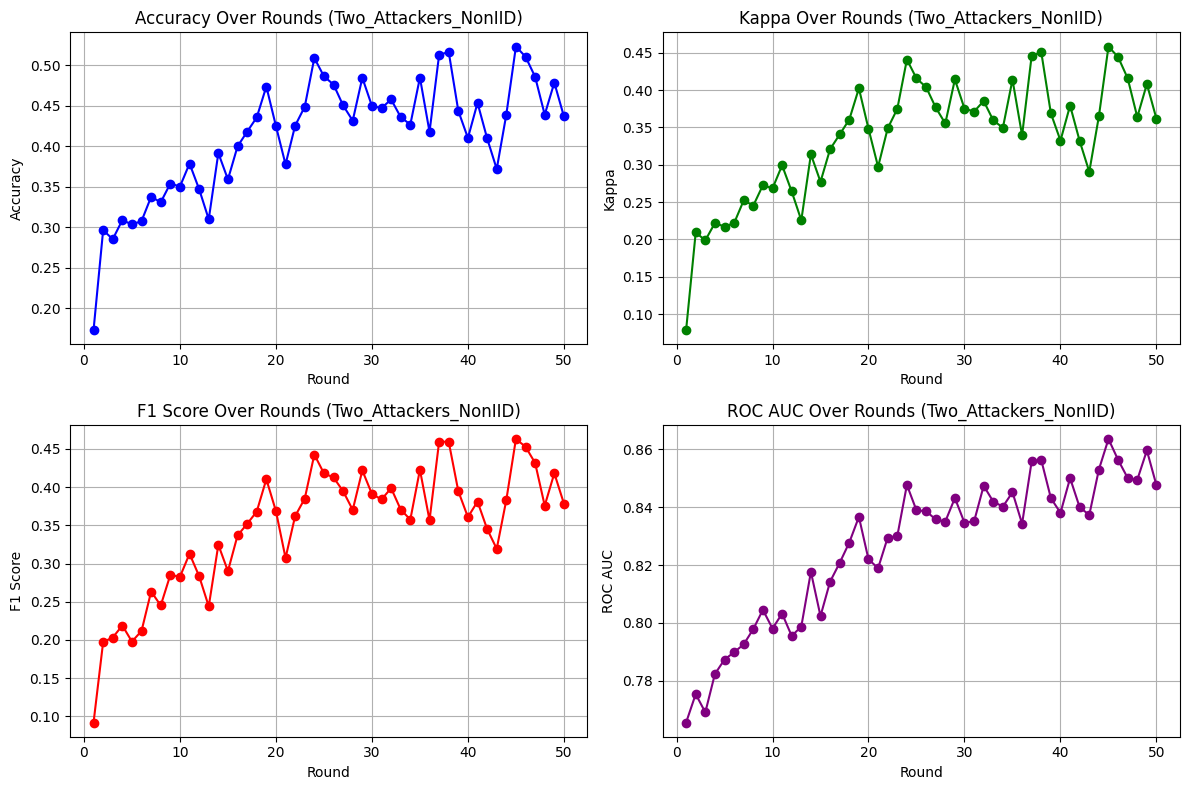


Best Parameters:
Scenario            Two_Attackers_NonIID
NOISE_MULTIPLIER                     0.5
CLIPPING_NORM                        5.0
Final_Accuracy                   0.48411
Name: 3, dtype: object


In [2]:
import itertools
import random

# Define ranges for NOISE_MULTIPLIER and CLIPPING_NORM
NOISE_MULTIPLIER_RANGE = [0.1, 0.5, 1.0, 2.0]  # Example values
CLIPPING_NORM_RANGE = [5.0, 10.0, 20.0, 50.0]  # Example values

# Define the number of random samples to test
NUM_RANDOM_SAMPLES = 10

# Generate all possible combinations
parameter_combinations = list(itertools.product(NOISE_MULTIPLIER_RANGE, CLIPPING_NORM_RANGE))

# Randomly sample a subset of combinations
random_combinations = random.sample(parameter_combinations, NUM_RANDOM_SAMPLES)

# Placeholder for results
grid_search_results = []

# Perform the randomized grid search
for noise_multiplier, clipping_norm in random_combinations:
    print(f"\nTesting with NOISE_MULTIPLIER={noise_multiplier}, CLIPPING_NORM={clipping_norm}")

    # Update the constants
    NOISE_MULTIPLIER = noise_multiplier
    CLIPPING_NORM = clipping_norm

    # Run the simulation with the current parameters
    results = run_all_scenarios()

    # Collect performance metrics (e.g., final accuracy or F1 score)
    for scenario_name, metrics in results.items():
        final_accuracy = metrics["accuracy"][-1]  # Take the accuracy from the last round
        grid_search_results.append({
            "Scenario": scenario_name,
            "NOISE_MULTIPLIER": noise_multiplier,
            "CLIPPING_NORM": clipping_norm,
            "Final_Accuracy": final_accuracy
        })

# Analyze results and find the best parameters
df_results = pd.DataFrame(grid_search_results)
best_result = df_results.loc[df_results["Final_Accuracy"].idxmax()]

print("\nBest Parameters:")
print(best_result)

# Save results to a CSV file
df_results.to_csv("grid_search_results.csv", index=False)
